In [1]:
import bq
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
client = bq.Client.Get()

In [3]:
# That gets you the schema with descriptions
schema = client.GetTableSchema({
    'projectId': 'ams-test-kostya', 
    'datasetId': 'full_test',  
    'tableId': 'full_test'
})

# Function that gets you the mask
bitFields = None
for field in schema['fields']:
    if field['name'] != 'selStatus': 
        continue
    bitFields = field['description'].split(',')
    break
    
get_cumulative_mask = lambda sel: (1 << bitFields.index(sel)) - 1

In [12]:
query = """
SELECT
  ROUND(10*R)/10 as RR,
  ROUND(100*BetaTOF)/100 as B,
  COUNT(1) as count
FROM
  full_test.full_test
WHERE
  R >= 0 AND R <= 10 AND BetaTOF < 1 AND BetaTOF > 0.4  AND
  R > Rcutoff AND selStatus&{mask}={mask}
GROUP BY RR, B
ORDER BY RR, B
""".format(mask=get_cumulative_mask('aRing'))

tableid = client.Query(query)['configuration']['query']['destinationTable']
bq_table = client.ReadTableRows(tableid)

Waiting on bqjob_r63d858eead21f99a_0000014d2454794e_2 ... (1s) Current status: DONE   


In [13]:
# Converting that to pandas dataframe
frame = pd.DataFrame(np.array(bq_table).astype(float), columns=['R','Beta','Count'])
frame = frame.set_index(['Beta','R']).unstack()['Count']
frame = frame.fillna(0).sort_index(ascending=False)

<matplotlib.colorbar.Colorbar instance at 0x56a4ec68>

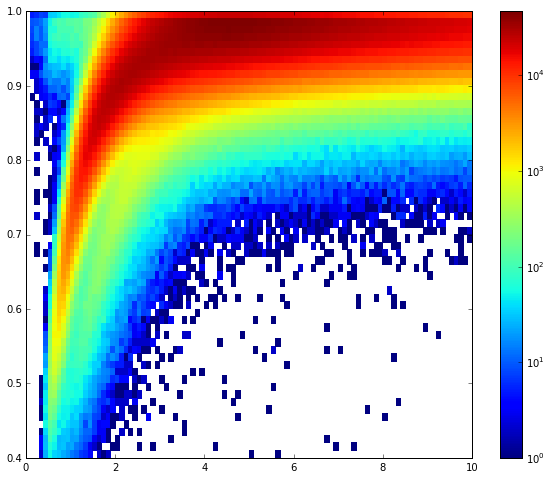

In [14]:
from matplotlib.colors import LogNorm

x,y = np.meshgrid(
    np.array(frame.index, dtype=float),
    np.array(frame.columns, dtype=float)
)

z = frame.T.values.astype(float)

figsize(10,8)
pcolor(y,x,z, norm=LogNorm(vmin=1,vmax=z.max()))
colorbar()